In [164]:
# Import all libraries

import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt

In [165]:
# Interesting Atoms as input

filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\traj2-55k-65k.npy"
data = np.load(filePath)
data.shape

(10000, 6126, 3)

In [166]:
# View Data Shape
# data = data[:200000]
# data = np.array(data)
# data.shape

In [167]:
# Transpose the data for Convoy algorithm

transposed_data = list()
for x in range(len(data[1])):
    
    transposed_data.append(data[:,x,0:3].tolist())

convoy_data = transposed_data
#convoy_data

In [168]:
# cluster = DBSCAN(eps=9, min_samples=4).fit(data[0])

# print("Number of Clusters = ", max(cluster.labels_)+1)

In [169]:
class ConvoyCandidate(object):
    """
    Attributes:
        indices(set): The object indices assigned to the convoy
        is_assigned (bool):
        start_time (int):  The start index of the convoy
        end_time (int):  The last index of the convoy
    """
    __slots__ = ('indices', 'is_assigned', 'start_time', 'end_time')

    def __init__(self, indices, is_assigned, start_time, end_time):
        self.indices = indices
        self.is_assigned = is_assigned
        self.start_time = start_time
        self.end_time = end_time

    def __repr__(self):
        return '<%r %r indices=%r, is_assigned=%r, start_time=%r, end_time=%r>' % (self.__class__.__name__, id(self), self.indices, self.is_assigned, self.start_time, self.end_time)

In [170]:
class CMC(object):
    """Coherence Moving Cluster (CMC) algorithm

    Attributes:
        k (int):  Min number of consecutive timestamps to be considered a convoy
        m (int):  Min number of elements to be considered a convoy
    """
    def __init__(self, clf, k, m):
        self.clf = clf
        self.k = k
        self.m = m

    def fit_predict(self, X, y=None, sample_weight=None):
        convoy_candidates = set()
        columns = len(X[0])
        column_iterator = range(columns)
        output_convoys = []

        for column in column_iterator:
            current_convoy_candidates = set()
            values = [row[column] if isinstance(row[column], (list, set)) else [row[column]] for row in X]
            if len(values) < self.m:
                continue
            clusters = self.clf.fit_predict(values, y=y, sample_weight=sample_weight)
            unique_clusters = set(clusters)
            clusters_indices = dict((cluster, ConvoyCandidate(indices=set(), is_assigned=False, start_time=None, end_time=None)) for cluster in unique_clusters)

            for index, cluster_assignment in enumerate(clusters):
                clusters_indices[cluster_assignment].indices.add(index)

            # update existing convoys
            for convoy_candidate in convoy_candidates:
                convoy_candidate_indices = convoy_candidate.indices
                convoy_candidate.is_assigned = False
                for cluster in unique_clusters:
                    cluster_indices = clusters_indices[cluster].indices
                    cluster_candidate_intersection = cluster_indices & convoy_candidate_indices
                    if len(cluster_candidate_intersection) < self.m:
                        continue
                    convoy_candidate.indices = cluster_candidate_intersection
                    current_convoy_candidates.add(convoy_candidate)
                    convoy_candidate.end_time = column
                    clusters_indices[cluster].is_assigned = convoy_candidate.is_assigned = True

                # check if candidates qualify as convoys
                candidate_life_time = (convoy_candidate.end_time - convoy_candidate.start_time) + 1
                if (not convoy_candidate.is_assigned or column == column_iterator[-1]) and candidate_life_time >= self.k:
                    output_convoys.append(convoy_candidate)

            # create new candidates
            for cluster in unique_clusters:
                cluster_data = clusters_indices[cluster]
                if cluster_data.is_assigned:
                    continue
                cluster_data.start_time = cluster_data.end_time = column
                current_convoy_candidates.add(cluster_data)
            convoy_candidates = current_convoy_candidates
        return output_convoys

In [171]:
# Clustering using DBSCAN
clustering_clf = DBSCAN(eps=2.13)


In [172]:
# # Test data of 3D Coordinates
# # Elements (Molecules) are in row, timesteps are in column

# test_data = ([[3,1,3],[3,2,4],[2,4,5]],
#         [[4,2,2],[6,2,3],[4,4,5]],
#         [[1,1,3],[51,2,-1],[55,3,0]],
#         [[51,2,1],[52,2,4],[56,-3, 2]])

In [173]:
# Min elements for convoy = m
# Min consecutive timesteps = k

clf = CMC(clustering_clf, k=50, m=30)

# Convoy calculation using Test data
convoys = clf.fit_predict(convoy_data)
print("Total number of Convoys =", len(convoys))

Total number of Convoys = 213


In [174]:
# # file = open("output.txt", "w")

# for convoy in convoys:
#     print('No of elements in the Convoy',len(convoy.indices))  
# #     for i in convoy.indices:
# #         print('%i: %r - Start Time: %r, End Time: %r' % (i, data[i], convoy.start_time, convoy.end_time))
#     print(convoy)
# #     file.write('%r - S: %r, E: %r\n' % (convoy.indices, convoy.start_time, convoy.end_time))
# #     file.write(str(convoy.start_time))
# #     file.write(str(convoy.end_time))
# # file.close()

In [181]:
df = pd.read_csv(r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\atom_list.csv")

for convoy in convoys:
    print('No of elements in this Convoy = ',len(convoy.indices))
    print(convoy)
#     print (sorted(convoy.indices))
    convoy_atom_type = list()
    for x in convoy.indices:
        convoy_atom_type.append(df.iloc[x].atom_type)
        
    print(convoy_atom_type)


No of elements in this Convoy =  44
<'ConvoyCandidate' 2289024863232 indices={2050, 2062, 2039, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2733, 2094, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2106, 2118, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2807, 2041}, is_assigned=False, start_time=0, end_time=499>
['os', 'os', 'c', 'ob', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'c', 'o', 'n', 'h1', 'os', 'h1', 'h1', 'h2', 'h1', 'h1', 'h1', 'hn', 'os', 'ob', 'h1', 'h1', 'h1', 'h2', 'h1', 'h1', 'h1', 'hn', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'h1', 'n']
No of elements in this Convoy =  47
<'ConvoyCandidate' 2289024964224 indices={4736, 4737, 4738, 4739, 4748, 4760, 4772, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5446, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4695, 5466, 5467, 5468, 5469, 5470, 5471, 4704, 4705, 4706, 4707, 5472, 5473, 4716, 4728, 4729, 4730, 4731, 4732, 4733, 47

<'ConvoyCandidate' 2289024926016 indices={4118, 4119, 4120, 4121, 4122, 4123, 4124, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3377, 3389, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3421, 3433, 4081, 4082, 4083, 4084, 3445, 4085, 4087, 4086}, is_assigned=False, start_time=0, end_time=2499>
['h1', 'h1', 'h1', 'h2', 'h1', 'h1', 'h1', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'os', 'os', 'ob', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'os', 'os', 'h1', 'h1', 'h1', 'h2', 'ob', 'h1', 'h1', 'h1']
No of elements in this Convoy =  44
<'ConvoyCandidate' 2289024862656 indices={1163, 396, 397, 398, 399, 400, 401, 402, 403, 1166, 405, 1167, 1168, 1169, 1170, 415, 427, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 458, 459, 471, 1164, 483, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1165}, is_assigned=False, start_time=1500, end_time=2499>
['h1', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'h2', 'o', 'h1', 'h1', 'h1', 'hn', 'os', 'os', 'ob', 'cb

['ob', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'c', 'o', 'n', 'os', 'hc', 'hc', 'h1', 'h1', 'h2', 'h1', 'h1', 'os', 'h1', 'hn', 'ob', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'h1', 'os', 'h1', 'h1', 'h2', 'h1', 'h1', 'h1', 'os']
No of elements in this Convoy =  31
<'ConvoyCandidate' 2289026057536 indices={779, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 791, 685, 686, 687, 1366, 1367, 1368, 1369, 748, 749, 750, 751, 752, 753, 754, 755, 756, 758, 759, 760, 766, 767}, is_assigned=False, start_time=3500, end_time=3999>
['os', 'h1', 'h1', 'h1', 'h2', 'h1', 'h1', 'h1', 'hn', 'ob', 'ca', 'c3', 'ca', 'ha', 'hc', 'hc', 'hc', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'c', 'n', 'ca', 'ca', 'ca', 'os']
No of elements in this Convoy =  40
<'ConvoyCandidate' 2289025534208 indices={1930, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1962, 1974, 2622, 2623, 2624, 2625, 1986, 2626, 2627, 2628, 2629, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 1899, 1900, 1901, 1902, 1903

<'ConvoyCandidate' 2289025086016 indices={132, 133, 134, 135, 136, 137, 138, 139, 904, 905, 906, 907, 908, 909, 910, 151, 163, 941, 942, 175, 176, 177, 178, 179, 180, 181, 182, 183, 943, 944, 945, 946, 947, 195, 207, 219}, is_assigned=False, start_time=8000, end_time=8999>
['cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'h1', 'h1', 'h1', 'h2', 'h1', 'h1', 'h1', 'os', 'os', 'h1', 'h1', 'ob', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'h1', 'h2', 'h1', 'h1', 'h1', 'os', 'os', 'ob']
No of elements in this Convoy =  45
<'ConvoyCandidate' 2289024730304 indices={5392, 5393, 5394, 5395, 5396, 5397, 5398, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 5409, 4660, 4661, 4662, 4663, 4664, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 4672, 5436, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4704, 4716, 4728}, is_assigned=False, start_time=8500, end_time=9499>
['h1', 'h1', 'h1', 'h2', 'h1', 'h1', 'h1', 'cb', 'cb', 'cb', 'cb', 'ob', 'cb', 'c3', 'os', 'hn', 'os', 'c', '

In [176]:
# filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Abdullah Data\ring_centers.npy"
# data = np.load(filePath)
# data = data[:200000]
# data = np.array(data)
# data.shape


In [177]:
filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\traj2-ca-55K-65K.npy"
data = np.load(filePath)

In [178]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data[5000])
distances, indices = nbrs.kneighbors(data[5000])

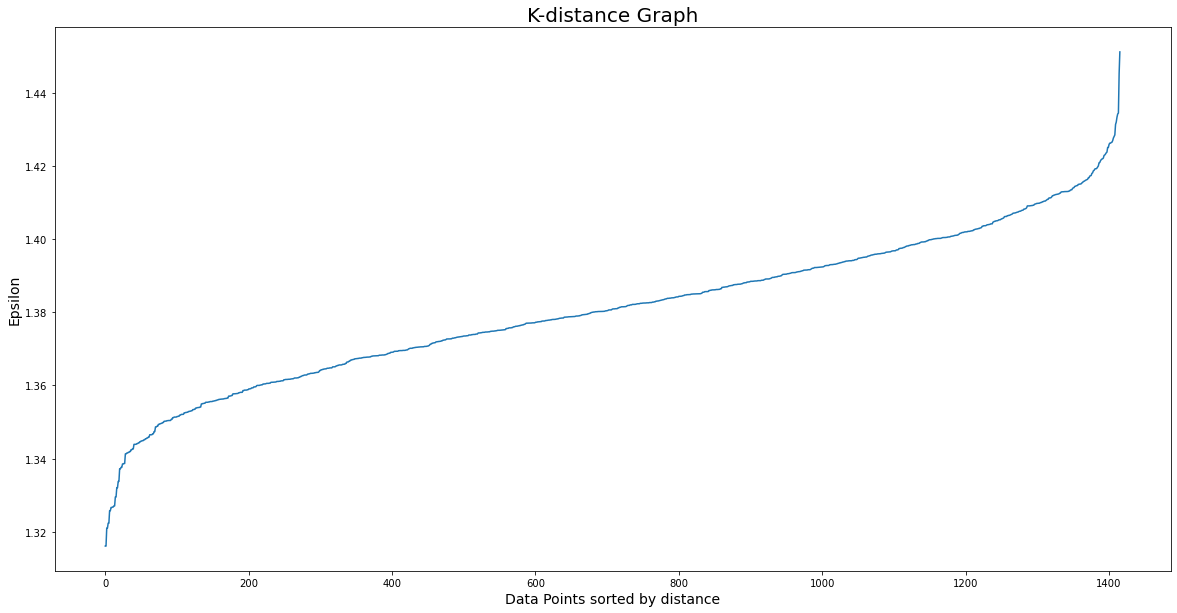

In [179]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()